Gene set scoring on single cells
Requires a complete adata (jan14 atlas adata works) in dir 'data'.
Also requires gene set files in data/. 

#Uses data from:
 https://www.tissuestabilitycellatlas.org/

In [1]:
import numpy as np
import scanpy as sc
from singscore.singscore import score
import pandas as pd
import seaborn as sns
%matplotlib inline
import matplotlib as plt
plt.rcParams["figure.figsize"] = (16,10)

In [2]:
def read_gene_sets(filepath):
    txt = open(filepath).read().split('\n')
    gd = dict()
    for line in txt:
        bits = line.split('\t')
        if len(bits) >= 3:
            gd[bits[0]] = bits[2:]
    return(gd)

In [3]:

def add_noise(df, n, noise_low, noise_high):
    df2 = df.copy()
    for i in range(0,n):
        df2['trial'+str(i)] = df * (1 + np.random.uniform(noise_low,noise_high,(df.shape)))
    return(df2)

def get_genecounts(adata, celli, count_threshold):
    avar = adata.var.copy()
    avar = avar.drop(['gene_ids', 'feature_types', 'genome', 'is_mito', 'is_ribo'], axis=1)
    gene_counts = adata.X[celli,:]
    if "toarray" in dir(gene_counts):
        avar['genecounts'] = gene_counts.toarray()[0]
    else:
        avar['genecounts'] = gene_counts.tolist()[0]
    avar_cut = avar[avar['genecounts'] > count_threshold]  ### MANY duplicate gene counts (i.e. 1)
    return(avar_cut)


def get_genecounts_csamp(adata, csamp, count_threshold):
    # get gene counts for a neighborhood sample
    avar = adata.var.copy()
    avar = avar.drop(['gene_ids', 'feature_types', 'genome', 'is_mito', 'is_ribo'], axis=1)
    gene_counts = adata.X[csamp,:]
    #if "toarray" in dir(gene_counts):
    #    avar['genecounts'] = gene_counts.toarray()[0]
    #else:
    #    avar['genecounts'] = gene_counts.tolist()[0]
    #avar_cut = avar[avar['genecounts'] > count_threshold]  ### MANY duplicate gene counts (i.e. 1)
    return(avar_cut)

        

In [4]:
def get_conn_dist(q, celli, nn):
    # q is an adata
    # celli is cell i in q
    # nn is the number of neighbors
    jdx = np.where(q.obsp['distances'][celli].todense() > 0)[1]
    y = [q.obsp['distances'][celli].todense().tolist()[0][ i ] for i in jdx]
    x = [q.obsp['connectivities'][celli].todense().tolist()[0][ i ] for i in jdx]
    df = pd.DataFrame({'idx':jdx, 'conn':x, 'dist':y})
    sumconn = sum(df['conn'])
    df['prob'] = [x/sumconn for x in df['conn']]
    return(df)

In [5]:
def getIndices(qx, gs):
    idx = []
    for gi in gs:
        res0 = np.where(qx.var.index == gi)[0]
        if len(res0) > 0:
            idx.append(res0[0])
    return(idx)

def simValueHigh(qx, gs):
    # first get the index to X for these genes
    idx = getIndices(qx, gs)
    qy = qx[:,idx[20]].X
    return(qy)

In [253]:
def neighborhood_scores(adata, noise_trials, num_neighbors, samp_neighbors, gene_set, mode):

    # mode 'average' averaged the noise trials
    # mode 'nonoise' returns the non-noised score 
    
    res0 = []
    numcells = adata.obs.shape[0]
    sc.pp.neighbors(adata, n_neighbors = num_neighbors)

    for celli in range(0, numcells):

        # first we get the neighborhood cells
        cdf = get_conn_dist(adata, celli, num_neighbors)

        # then we sample a set of cells from them
        csamp = np.random.choice(a=cdf['idx'], size=samp_neighbors, replace=False, p=cdf['prob'])

        # gene counts for scoring needs to have genes on rows.
        gene_counts = adata.X[csamp,:]
        gene_mat = gene_counts.todense()
        gene_mat = gene_mat.transpose().tolist()

        # get index of genes with some counts across cells
        gdx = [i for i,j in enumerate(gene_mat) if sum(j) > 0.0]  ## could filter here

        # sum gene counts across cells
        gene_mat_sum = [sum(x) for x in gene_mat]
        df = pd.DataFrame(gene_mat_sum, index=adata.var.index)
        df = df.iloc[gdx,:]

        if mode == 'average' and noise_trials > 0:
            # add some noise to gene counts.. create a n numbers of examples
            df_noise = add_noise(df, noise_trials, 0.01, 0.49)
            # score the neighborhoods
            si = score(up_gene=gene_set, sample=df_noise, norm_method='standard', full_data=False)  # standard workin gbetter here than theoretical
            res0.append(sum(si['total_score'][1:])/ float(noise_trials))
        else:
            si = score(up_gene=gene_set, sample=df, norm_method='standard', full_data=False) 
            res0.append(float(si['total_score'][0]))
            
    return(res0)

In [7]:
def one_score(adata, celli, noise_trials, num_neighbors, samp_neighbors, gene_set, 
              mode='average', compute_neighbors=True):

    # mode 'average' averaged the noise trials
    # mode 'nonoise' returns the non-noised score 
    
    if num_neighbors == 0 and samp_neighbors > 0:
        print('fix parameters')
        return(False)
    
    numcells = adata.obs.shape[0]
    
    if compute_neighbors == True and num_neighbors > 0:
        sc.pp.neighbors(adata, n_neighbors = num_neighbors)
        
    if num_neighbors > 0:
        # first we get the neighborhood cells
        cdf = get_conn_dist(adata, celli, num_neighbors)
        
        # then we sample a set of cells from them
        csamp = np.random.choice(a=cdf['idx'], size=samp_neighbors, replace=False, p=cdf['prob'])
        # gene counts for scoring needs to have genes on rows.
        gene_counts = adata.X[csamp,:]
    else:
        # one cell
        gene_counts = adata.X[celli,:]
        
    gene_mat = gene_counts.todense()    
    gene_mat = gene_mat.transpose().tolist()
    
    # get index of genes with some counts across cells
    gdx = [i for i,j in enumerate(gene_mat) if sum(j) > 0.0]  ## could filter here
    # sum gene counts across cells
    gene_mat_sum = [sum(x) for x in gene_mat]
    df = pd.DataFrame(gene_mat_sum, index=adata.var.index)
    df = df.iloc[gdx,:]
        
    if mode == 'average' and noise_trials > 0:
        # add some noise to gene counts.. create a n numbers of examples
        df_noise = add_noise(df, noise_trials, 0.01, 0.99)
        # score the neighborhoods
        si = score(up_gene=gene_set, sample=df_noise, norm_method='standard', full_data=False)  # standard workin gbetter here than theoretical
    else:
        si = score(up_gene=gene_set, sample=df, norm_method='standard', full_data=False) 
        
    return(si)

In [189]:
def one_score_med(adata, celli, noise_trials, num_neighbors, samp_neighbors, gene_set, 
              mode='average', compute_neighbors=True):

    # mode 'average' averaged the noise trials
    # mode 'nonoise' returns the non-noised score 
    
    if num_neighbors == 0 and samp_neighbors > 0:
        print('fix parameters')
        return(False)
    
    numcells = adata.obs.shape[0]
    
    if compute_neighbors == True and num_neighbors > 0:
        sc.pp.neighbors(adata, n_neighbors = num_neighbors)
        
    if num_neighbors > 0:
        # first we get the neighborhood cells
        cdf = get_conn_dist(adata, celli, num_neighbors)
        
        # then we sample a set of cells from them
        csamp = np.random.choice(a=cdf['idx'], size=samp_neighbors, replace=False, p=cdf['prob'])
        # gene counts for scoring needs to have genes on rows.
        gene_counts = adata.X[csamp,:]
    else:
        # one cell
        gene_counts = adata.X[celli,:]
        
    gene_mat = gene_counts.todense()    
    gene_mat = gene_mat.transpose().tolist()
    
    # get index of genes with some counts across cells
    gdx = [i fornoise_trialsnumerate(gene_mat) if sum(j) > 0.0]  ## could filter here
    # median value after excluding zeros?
    gene_mat_sum = [np.median(np.array(x)[np.array(x)>0.0]) for x in gene_mat]
    df = pd.DataFrame(gene_mat_sum, index=adata.var.index)
    df = df.iloc[gdx,:]
        
    if mode == 'average' and noise_trials > 0:
        # add some noise to gene counts.. create a n numbers of examples
        df_noise = add_noise(df, noise_trials, 0.01, 0.99)
        # score the neighborhoods
        si = score(up_gene=gene_set, sample=df_noise, norm_method='standard', full_data=False)  # standard workin gbetter here than theoretical
    else:
        si = score(up_gene=gene_set, sample=df, norm_method='standard', full_data=False) 
        
    return(si)

In [142]:
q = sc.read_h5ad('../data/oesophagus.cellxgene.h5ad')
#q = sc.read_h5ad('../data/Atlas_adatas_June2021_celltypes_Bcells.h5ad')
# subset some cells
#q.obs.CL_name.value_counts()
q.obs.Celltypes_updated_July_2020.value_counts()

Epi_stratified                  50469
Epi_suprabasal                  10870
Epi_basal                       10000
Epi_upper                        9150
Endothelia_vascular_venous       1392
T_CD4                            1350
Glands_duct                       804
T_CD8                             797
B_CD27pos                         773
B_CD27neg                         462
Fibroblast                        429
Dendritic_Cells                   337
Mono_macro                        334
NK_T_CD8_Cytotoxic                201
Endothelia_vascular_arterial      175
Muscle                            114
Mast_cell                         112
Endothelia_Lymphatic              110
Glands_mucous                      68
Name: Celltypes_updated_July_2020, dtype: int64

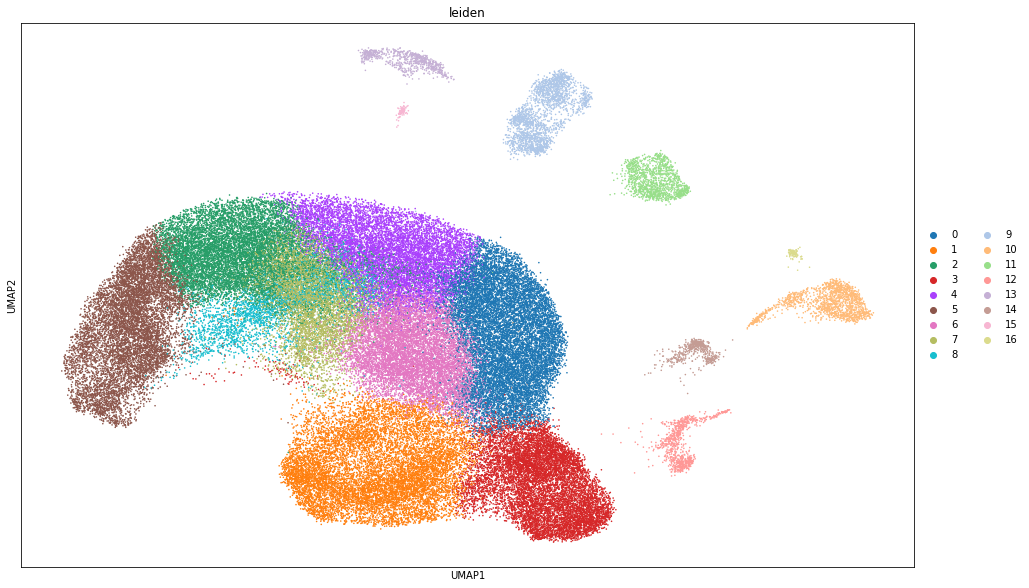

In [143]:
sc.pl.umap(q, color='leiden', size=10)

In [160]:
f(True)

'Bcells'

In [159]:
def f(x):
    if x:
        return('Bcells')
    else:
        return('Non-Bs')

idx = (q.obs.Celltypes_updated_July_2020 == 'B_CD27pos') | (q.obs.Celltypes_updated_July_2020 == 'B_CD27neg')
q.obs['Bcells'] = [f(x) for x in idx]

... storing 'Bcells' as categorical


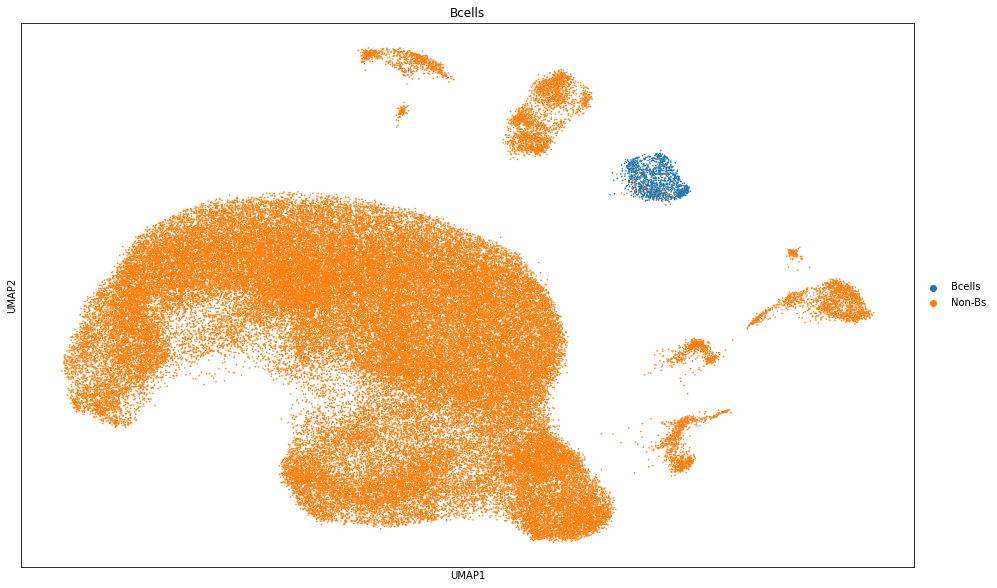

In [161]:
sc.pl.umap(q, color='Bcells', size=10)

In [163]:
# examples running on a smaller set of cells

subq = q[q.obs.Bcells == 'Bcells']
#subq.obs
#subq = q

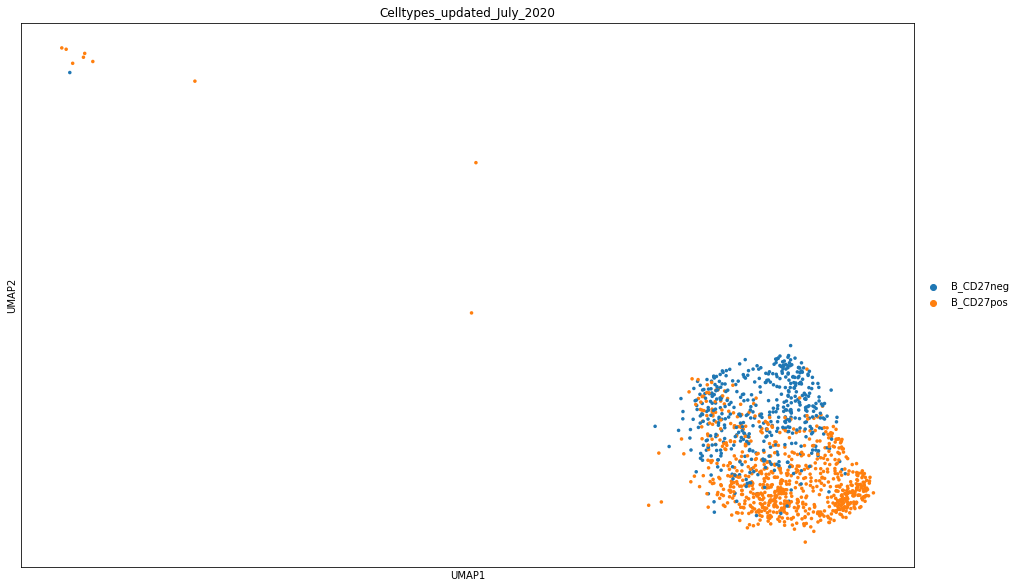

In [164]:
sc.pl.umap(subq, color='Celltypes_updated_July_2020', size=50)

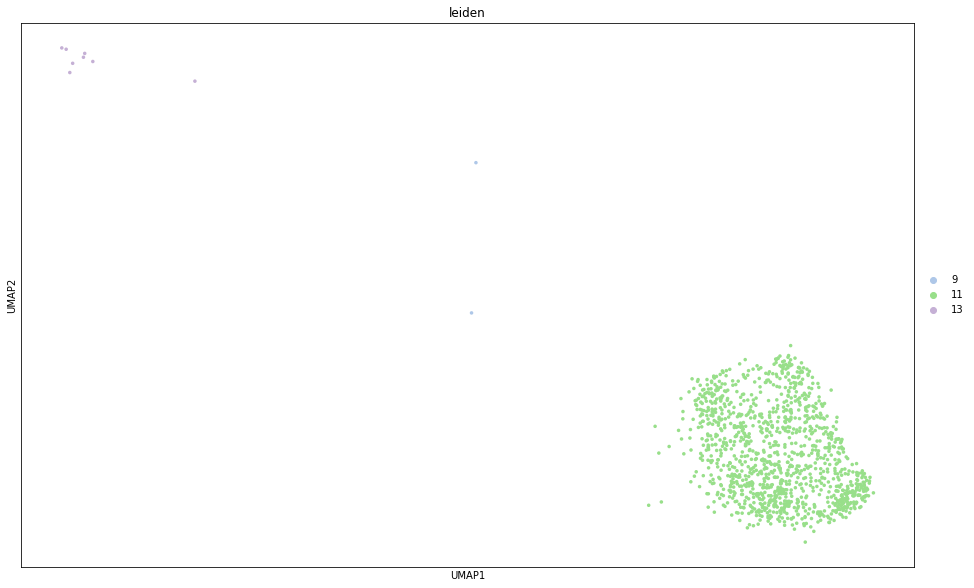

In [165]:
sc.pl.umap(subq, color='leiden', size=50)

In [166]:
sc.tl.rank_genes_groups(adata=subq, groupby='Celltypes_updated_July_2020',key_added='BcellDEG')

Trying to set attribute `.uns` of view, copying.


In [174]:
degs = subq.uns['BcellDEG']['names']
gene_set1 = [x[0] for x in degs]
gene_set = gene_set1[0:50]

In [28]:
# read in more gene sets
gd = read_gene_sets('../genesets/h.all.v7.2.symbols.gmt')
gs1 = gd['HALLMARK_TNFA_SIGNALING_VIA_NFKB']
gs2 = gd['HALLMARK_INTERFERON_ALPHA_RESPONSE']
#print(len(gd['HALLMARK_TNFA_SIGNALING_VIA_NFKB']))
#print(gs[0:5])
gs_list = [gs1, gs2]

In [35]:
gene_set = gs2

In [31]:
gd.keys()

dict_keys(['HALLMARK_TNFA_SIGNALING_VIA_NFKB', 'HALLMARK_HYPOXIA', 'HALLMARK_CHOLESTEROL_HOMEOSTASIS', 'HALLMARK_MITOTIC_SPINDLE', 'HALLMARK_WNT_BETA_CATENIN_SIGNALING', 'HALLMARK_TGF_BETA_SIGNALING', 'HALLMARK_IL6_JAK_STAT3_SIGNALING', 'HALLMARK_DNA_REPAIR', 'HALLMARK_G2M_CHECKPOINT', 'HALLMARK_APOPTOSIS', 'HALLMARK_NOTCH_SIGNALING', 'HALLMARK_ADIPOGENESIS', 'HALLMARK_ESTROGEN_RESPONSE_EARLY', 'HALLMARK_ESTROGEN_RESPONSE_LATE', 'HALLMARK_ANDROGEN_RESPONSE', 'HALLMARK_MYOGENESIS', 'HALLMARK_PROTEIN_SECRETION', 'HALLMARK_INTERFERON_ALPHA_RESPONSE', 'HALLMARK_INTERFERON_GAMMA_RESPONSE', 'HALLMARK_APICAL_JUNCTION', 'HALLMARK_APICAL_SURFACE', 'HALLMARK_HEDGEHOG_SIGNALING', 'HALLMARK_COMPLEMENT', 'HALLMARK_UNFOLDED_PROTEIN_RESPONSE', 'HALLMARK_PI3K_AKT_MTOR_SIGNALING', 'HALLMARK_MTORC1_SIGNALING', 'HALLMARK_E2F_TARGETS', 'HALLMARK_MYC_TARGETS_V1', 'HALLMARK_MYC_TARGETS_V2', 'HALLMARK_EPITHELIAL_MESENCHYMAL_TRANSITION', 'HALLMARK_INFLAMMATORY_RESPONSE', 'HALLMARK_XENOBIOTIC_METABOLISM', 'HAL

In [202]:
# what cell we'll look at
celli = 3

[Text(0.5, 0, 'Connectivities'), Text(0, 0.5, 'Distances')]

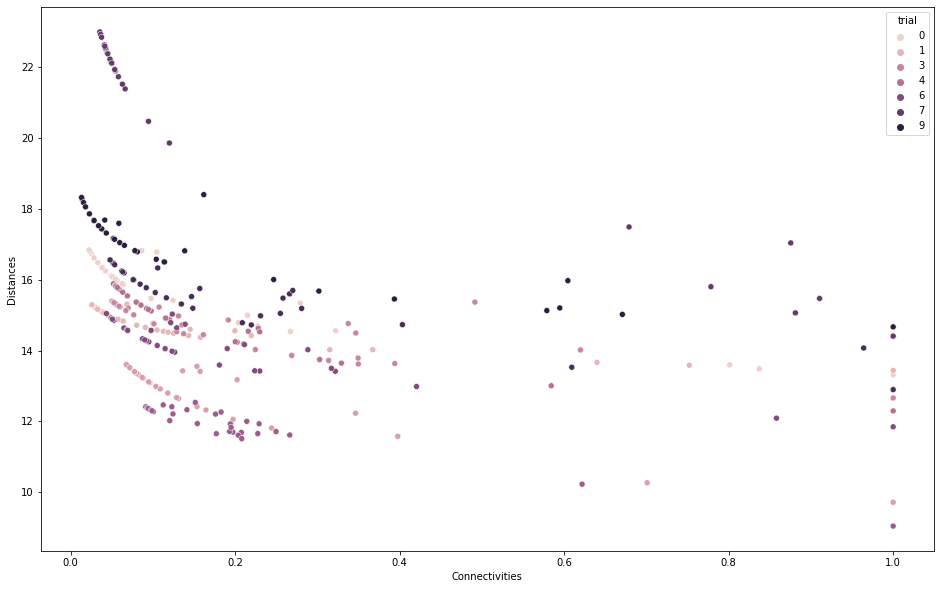

In [203]:
# plotting distance vs connectivity for cells

noise_trials = 33  # number of noise cells to make
num_neighbors = 33
samp_neighbors = 27

sc.pp.neighbors(subq, n_neighbors = num_neighbors)

bigdf = pd.DataFrame()
for i in range(0,10):
    df = get_conn_dist(subq, i, 40)  # make a table of distances and connectivities
    df['trial'] = i
    bigdf = pd.concat([bigdf,df], ignore_index=True)
ax = sns.scatterplot(data=bigdf, x='conn', y='dist', hue='trial')
ax.set(xlabel='Connectivities', ylabel='Distances')
#plt.show()

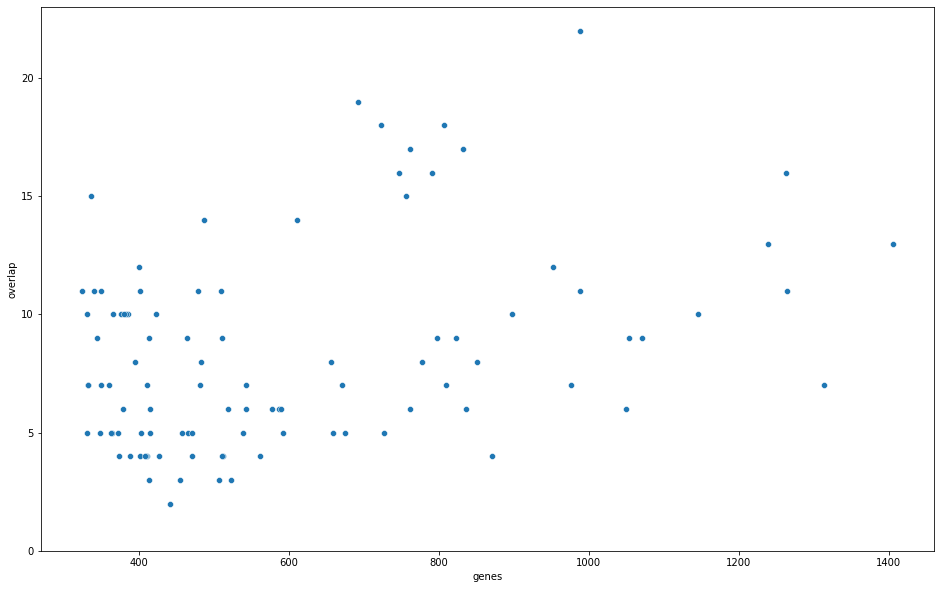

In [204]:
# plotting the number of genes overlaping with a given gene set
# with a random cell

genes_expressed = []
overlap = []

ncells = len(subq)

cell_index = np.random.randint(low=0, high=len(subq), size=100)   # random cell

for i in cell_index:
    idx = np.where(subq.X[i,:].todense().tolist()[0])[0]
    genes_expressed.append( len(idx) )
    overlap.append( len(set(subq.var.index[idx].tolist()).intersection(gene_set)) )

df_overlap = pd.DataFrame( {'genes':genes_expressed, 'overlap':overlap} )

ax = sns.scatterplot(data=df_overlap, x='genes', y='overlap')
ax.set_ylim(bottom=0);

In [177]:
len(gene_set)

50

computing neighbors


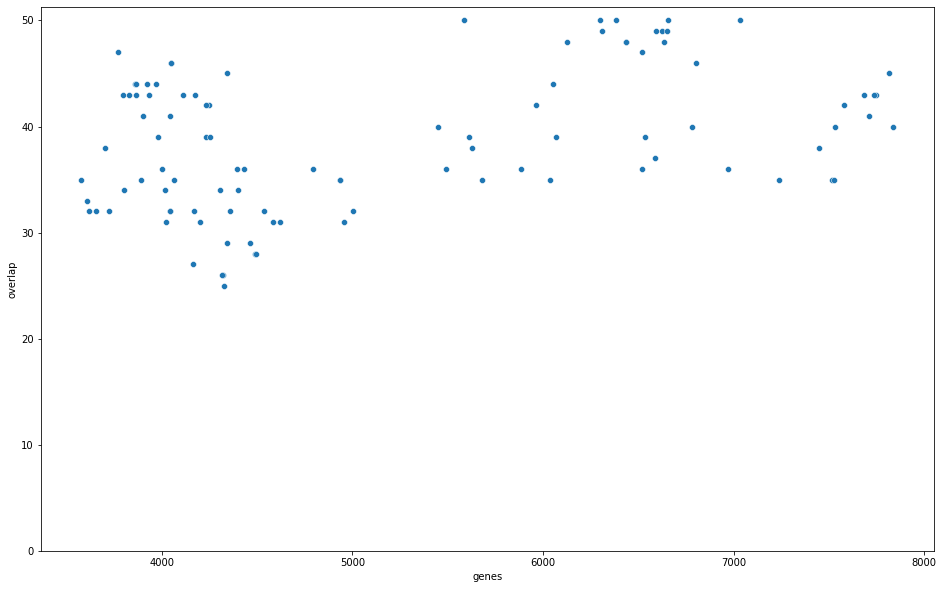

In [205]:
# plotting gene set overlap after considering neighborhood

num_neighbors = 31
samp_neighbors = 30

genes_expressed = []
overlap = []

print('computing neighbors')
sc.pp.neighbors(subq, n_neighbors = num_neighbors)

cell_index = np.random.randint(low=0, high=len(subq), size=100)

for i in cell_index:

    # first we get the neighborhood cells
    cdf = get_conn_dist(subq, i, num_neighbors)

    # then we sample a set of cells from them
    csamp = np.random.choice(a=cdf['idx'], size=samp_neighbors, replace=False, p=cdf['prob'])

    # gene counts for scoring needs to have genes on rows.
    gene_counts = subq.X[csamp,:]
    gene_mat = gene_counts.todense()
    gene_mat = gene_mat.transpose().tolist()

    # get index of genes with some counts across cells
    gdx = [i for i,j in enumerate(gene_mat) if sum(j) > 0.0]  ## could filter here

    # sum gene counts across cells
    gene_mat_sum = [sum(x) for x in gene_mat]
    df = pd.DataFrame(gene_mat_sum, index=subq.var.index)
    df = df.iloc[gdx,:]

    genes_expressed.append( len(gdx) )
    overlap.append( len(set(df.index.tolist()).intersection(gene_set)) )

df_overlap = pd.DataFrame({'genes':genes_expressed, 'overlap':overlap})

ax = sns.scatterplot(data=df_overlap, x='genes', y='overlap')
ax.set_ylim(bottom=0);

In [206]:
df_overlap

,genes,overlap
0,6520,47
1,7814,45
2,4043,32
3,4792,36
4,6971,36
...,...,...
95,7836,40
96,6307,49
97,4933,35
98,4043,32


In [207]:
# gene set scoring on one cell
celli = 3
noise_trials = 0
num_neighbors = 0
samp_neighbors = 0
mode ='average'

si = one_score(subq, celli, noise_trials, num_neighbors, samp_neighbors, gene_set, mode, compute_neighbors=True)

print(si)

#sns.kdeplot(data=si, x='total_score')


   total_score
0    -0.017094


In [208]:
# gene set scoring on one cell with noise

noise_trials = 50
num_neighbors = 0
samp_neighbors = 0
mode ='average'

for gset in gd:
    si = one_score(subq, celli, noise_trials, num_neighbors, samp_neighbors, gd[gset], mode, compute_neighbors=True)
    print(gset + '  ' + str(np.mean(si)))
    

#sns.kdeplot(data=si, x='total_score')


HALLMARK_TNFA_SIGNALING_VIA_NFKB  total_score    0.027203
dtype: float64
HALLMARK_HYPOXIA  total_score    0.02723
dtype: float64
HALLMARK_CHOLESTEROL_HOMEOSTASIS  total_score    0.04721
dtype: float64
HALLMARK_MITOTIC_SPINDLE  total_score   -0.146293
dtype: float64
HALLMARK_WNT_BETA_CATENIN_SIGNALING  total_score   -0.166399
dtype: float64
HALLMARK_TGF_BETA_SIGNALING  total_score    0.010642
dtype: float64
HALLMARK_IL6_JAK_STAT3_SIGNALING  total_score   -0.036032
dtype: float64
HALLMARK_DNA_REPAIR  total_score   -0.086636
dtype: float64
HALLMARK_G2M_CHECKPOINT  total_score   -0.084945
dtype: float64
HALLMARK_APOPTOSIS  total_score   -0.019926
dtype: float64
HALLMARK_NOTCH_SIGNALING  total_score   -0.158069
dtype: float64
HALLMARK_ADIPOGENESIS  total_score   -0.050774
dtype: float64
HALLMARK_ESTROGEN_RESPONSE_EARLY  total_score    0.007849
dtype: float64
HALLMARK_ESTROGEN_RESPONSE_LATE  total_score    0.045685
dtype: float64
HALLMARK_ANDROGEN_RESPONSE  total_score   -0.089505
dtype: flo

/home/daveg/.local/lib/python3.8/site-packages/numpy/core/fromnumeric.py:3372: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/home/daveg/.local/lib/python3.8/site-packages/numpy/core/_methods.py:170: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


HALLMARK_HEDGEHOG_SIGNALING  total_score   NaN
dtype: float64
HALLMARK_COMPLEMENT  total_score   -0.070893
dtype: float64
HALLMARK_UNFOLDED_PROTEIN_RESPONSE  total_score    0.053819
dtype: float64
HALLMARK_PI3K_AKT_MTOR_SIGNALING  total_score   -0.1018
dtype: float64
HALLMARK_MTORC1_SIGNALING  total_score   -0.060483
dtype: float64
HALLMARK_E2F_TARGETS  total_score   -0.116335
dtype: float64
HALLMARK_MYC_TARGETS_V1  total_score    0.082792
dtype: float64
HALLMARK_MYC_TARGETS_V2  total_score    0.006425
dtype: float64
HALLMARK_EPITHELIAL_MESENCHYMAL_TRANSITION  total_score    0.007469
dtype: float64
HALLMARK_INFLAMMATORY_RESPONSE  total_score    0.032881
dtype: float64
HALLMARK_XENOBIOTIC_METABOLISM  total_score   -0.154701
dtype: float64
HALLMARK_FATTY_ACID_METABOLISM  total_score   -0.027109
dtype: float64
HALLMARK_OXIDATIVE_PHOSPHORYLATION  total_score   -0.051339
dtype: float64
HALLMARK_GLYCOLYSIS  total_score   -0.039262
dtype: float64
HALLMARK_REACTIVE_OXYGEN_SPECIES_PATHWAY  tota

In [57]:
gene_set = gd['HALLMARK_INFLAMMATORY_RESPONSE']

In [209]:
celli

3

         total_score
0           0.294084
trial0      0.278582
trial1      0.292403
trial2      0.285410
trial3      0.295693
trial4      0.291227
trial5      0.285673
trial6      0.280367
trial7      0.290593
trial8      0.286859
trial9      0.291294
trial10     0.287349
trial11     0.281888
trial12     0.287658
trial13     0.291928
trial14     0.297910
trial15     0.294790
trial16     0.294543
trial17     0.285235
trial18     0.290288
trial19     0.284255
trial20     0.285188
trial21     0.303599
trial22     0.281996
trial23     0.288071
trial24     0.289262
trial25     0.280300
trial26     0.274338
trial27     0.289278
trial28     0.286833
trial29     0.284208
trial30     0.292944
trial31     0.290799
trial32     0.301933
trial33     0.294166
trial34     0.294806
trial35     0.290258
trial36     0.291861
trial37     0.291077
trial38     0.296482
trial39     0.285178
trial40     0.289793
trial41     0.289087
trial42     0.293027
trial43     0.295600
trial44     0.287839
trial45     0

<AxesSubplot:xlabel='total_score', ylabel='Density'>

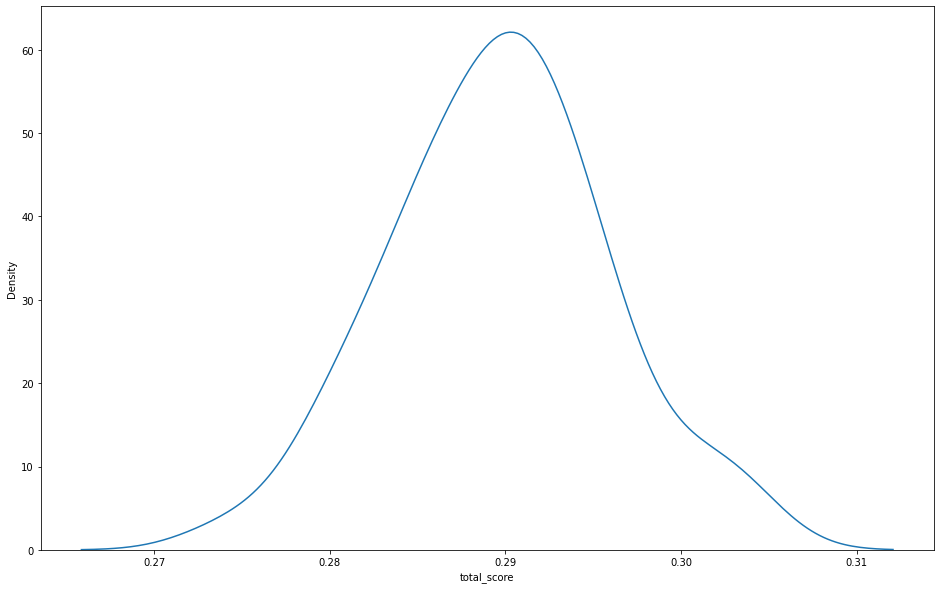

In [236]:
# gene set scoring on one cell with noise

celli = 3 #119
noise_trials = 50
num_neighbors = 30
samp_neighbors = 21
mode ='average'

si = one_score(subq, celli, noise_trials, num_neighbors, samp_neighbors, gene_set, mode, compute_neighbors=True)

print(si)

sns.kdeplot(data=si, x='total_score')


In [225]:
# with sampling more neighbors, score rises and levels off #
# sample all of the neighborhood (as much as possible)

noise_trials = 0
mode ='average'
res0 = [] ### list of scores
celli = 3

for num_neighbors in range(2, 100):
    samp_neighbors = num_neighbors-1
    res1 = one_score(subq, celli, noise_trials, num_neighbors, samp_neighbors, gene_set, mode, compute_neighbors=True)
    res0.append(res1.total_score[0])


<AxesSubplot:xlabel='Number of Neighbors', ylabel='Gene Set Score'>

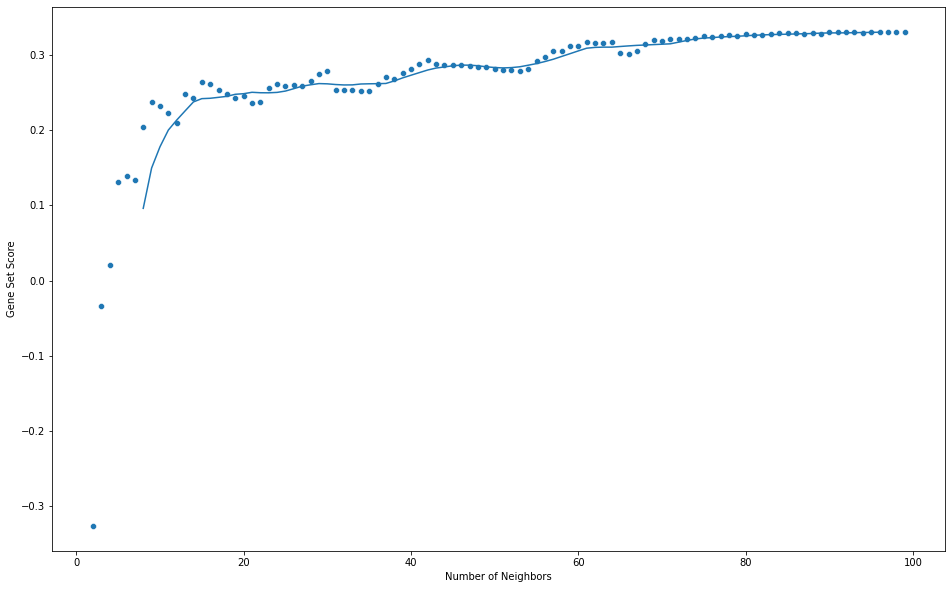

In [226]:
# plotting the score vs neighborhood size

df = pd.DataFrame({'Number of Neighbors':range(2,100), 'Gene Set Score': res0})
df['Score Avg'] = df['Gene Set Score'].rolling(10).mean().shift(-3)
sns.scatterplot(data=df, x='Number of Neighbors', y='Gene Set Score')
sns.lineplot(data=df, x='Number of Neighbors', y='Score Avg')


In [227]:
# with sampling more neighbors, score rises and levels off #
# sample all of the neighborhood (as much as possible)

noise_trials = 0
mode ='average'
res0 = [] ### list of scores
celli = 3
samp_neighbors = 21
    
for num_neighbors in range(25, 100):

    res1 = one_score(subq, celli, noise_trials, num_neighbors, samp_neighbors, gene_set, mode, compute_neighbors=True)
    res0.append(res1.total_score[0])


(0.0, 102.7)

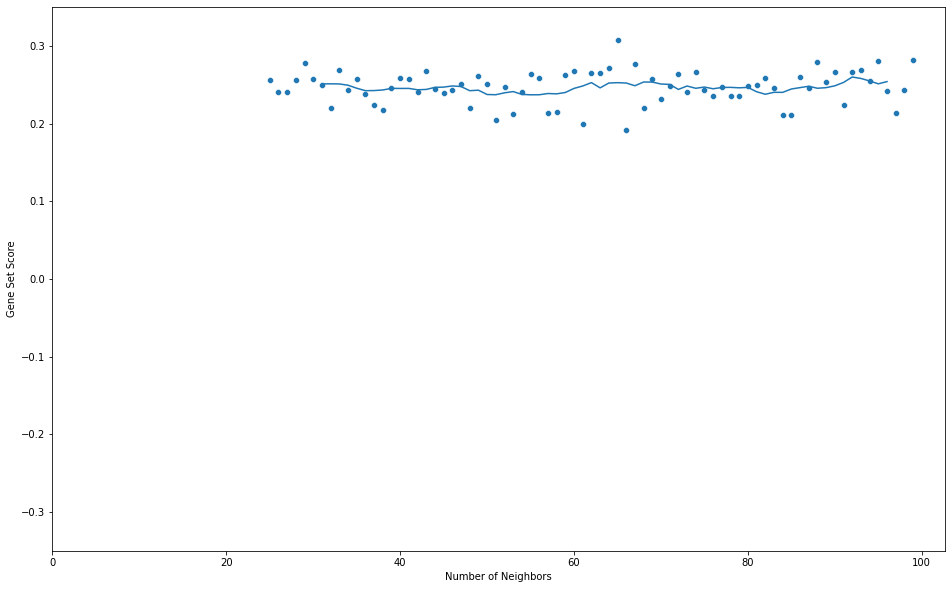

In [230]:
# plotting the score vs neighborhood size

df = pd.DataFrame({'Number of Neighbors':range(25,100), 'Gene Set Score': res0})
df['Score Avg'] = df['Gene Set Score'].rolling(10).mean().shift(-3)
sns.scatterplot(data=df, x='Number of Neighbors', y='Gene Set Score')
ax = sns.lineplot(data=df, x='Number of Neighbors', y='Score Avg', )
ax.set_ylim(bottom=-0.35, top =0.35);
ax.set_xlim(xmin=0)

In [232]:
# now fix neighbors and increase sample size

celli = 3
noise_trials = 0
num_neighbors = 100
mode ='average'
res0 = []

for samp_neighbors in range(2, 99):
    #samp_neighbors = num_neighbors-1
    res1 = one_score(subq, celli, noise_trials, num_neighbors, samp_neighbors, gene_set, mode, compute_neighbors=True)
    res0.append(res1.total_score[0])


(0.0, 102.8)

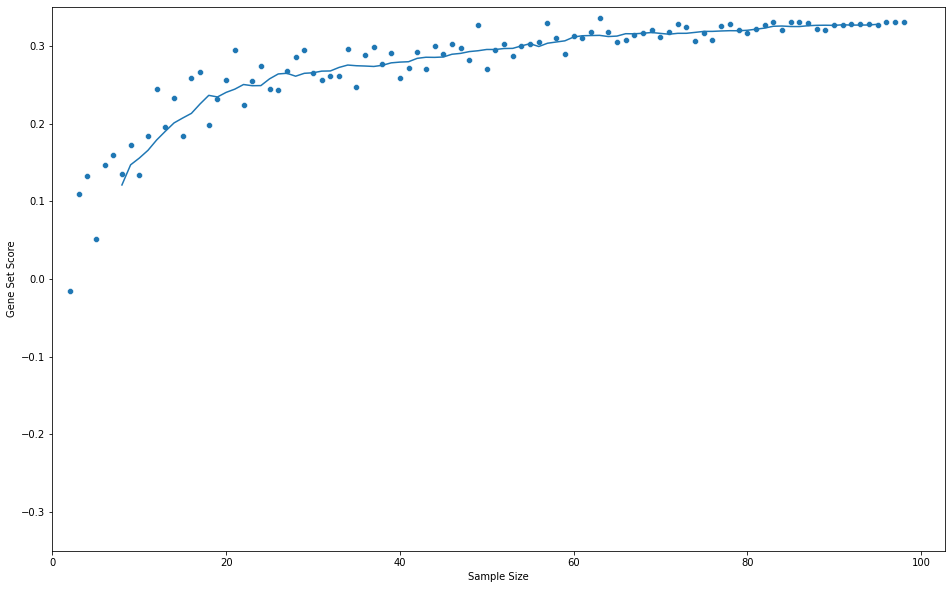

In [233]:
# plotting effect of increasing sample size

#ax = sns.scatterplot(x = range(2,99), y = res0)
df = pd.DataFrame({'Sample Size':range(2,99), 'Gene Set Score': res0})
df['Score Avg'] = df['Gene Set Score'].rolling(10).mean().shift(-3)
sns.scatterplot(data=df, x='Sample Size', y='Gene Set Score')
ax = sns.lineplot(data=df, x='Sample Size', y='Score Avg')
ax.set_ylim(bottom=-0.35, top =0.35);
ax.set_xlim(xmin=0)

In [216]:
# now we are increasing the sample size
# and taking the mean over noised data

noise_trials = 50
num_neighbors = 100
mode ='average'
res2 = []

for samp_neighbors in range(2, 99):
    res3 = one_score(subq, celli, noise_trials, num_neighbors, samp_neighbors, gene_set, mode, compute_neighbors=True)
    res2.append(res3.total_score[1:50].sum() / 50)


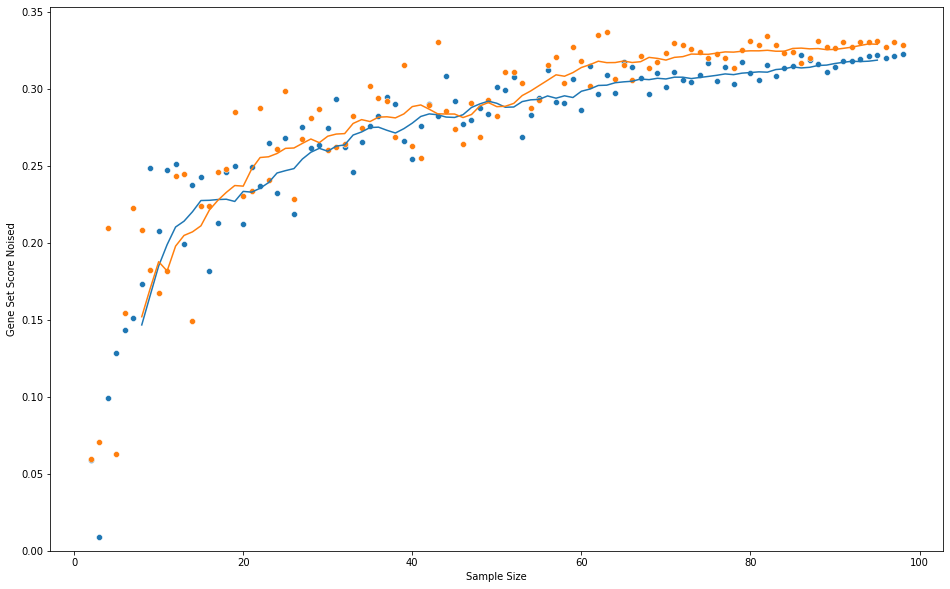

In [218]:
# plotting effect of adding noise
# with the previous plot increasing sample size with no noise
# this has a rolling 7 point average

#ax = sns.scatterplot(x = range(2,99), y = res0)
df = pd.DataFrame({'Sample Size':range(2,99), 'Gene Set Score No Noise': res0, 'Gene Set Score Noised': res2})
df['Noised Score Avg'] = df['Gene Set Score Noised'].rolling(10).mean().shift(-3)
df['No Noise Score Avg'] = df['Gene Set Score No Noise'].rolling(10).mean().shift(-3)
ax = sns.scatterplot(data=df, x='Sample Size', y='Gene Set Score Noised', palette="deep")
sns.lineplot(data=df, x='Sample Size', y='Noised Score Avg',palette="deep")
sns.scatterplot(data=df, x='Sample Size', y='Gene Set Score No Noise')
sns.lineplot(data=df, x='Sample Size', y='No Noise Score Avg')
ax.set_ylim(bottom=-0.0);


In [245]:
# same plot as before, but looking at smaller neighborhood (50)

# plotting effect of adding noise
# with the previous plot increasing sample size with no noise
# this has a rolling 7 point average

celli = 3

res0 = []
noise_trials = 0
num_neighbors = 50
mode ='average'

for samp_neighbors in range(2, 49):
    res1 = one_score(subq, celli, noise_trials, num_neighbors, samp_neighbors, gene_set, mode, compute_neighbors=True)
    res0.append(res1.total_score[0])


noise_trials = 50
num_neighbors = 50
mode ='average'
res2 = []

for samp_neighbors in range(2, 49):
    res3 = one_score(subq, celli, noise_trials, num_neighbors, samp_neighbors, gene_set, mode, compute_neighbors=True)
    res2.append(res3.total_score[1:30].sum() / 30)


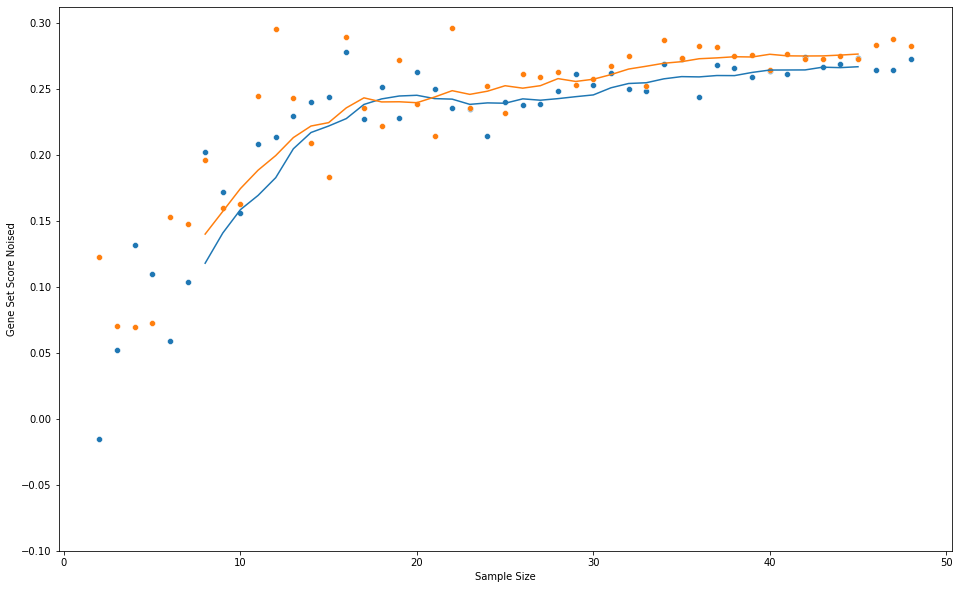

In [246]:
#ax = sns.scatterplot(x = range(2,99), y = res0)
df = pd.DataFrame({'Sample Size':range(2,49), 'Gene Set Score No Noise': res0, 'Gene Set Score Noised': res2})
df['Noised Score Avg'] = df['Gene Set Score Noised'].rolling(10).mean().shift(-3)
df['No Noise Score Avg'] = df['Gene Set Score No Noise'].rolling(10).mean().shift(-3)
ax = sns.scatterplot(data=df, x='Sample Size', y='Gene Set Score Noised', palette='tab:red')
sns.lineplot(data=df, x='Sample Size', y='Noised Score Avg')
sns.scatterplot(data=df, x='Sample Size', y='Gene Set Score No Noise')
sns.lineplot(data=df, x='Sample Size', y='No Noise Score Avg')
ax.set_ylim(bottom=-0.1);


In [27]:
import gc
gc.collect()

2927

In [28]:
# making a new data set

tcells = q[q.obs.celltypes_auto == 'T cells']
nkcells = q[q.obs.celltypes_auto == 'NK cells']

/home/daveg/.local/lib/python3.8/site-packages/pandas/core/arrays/categorical.py:2487: FutureWarning: The `inplace` parameter in pandas.Categorical.remove_unused_categories is deprecated and will be removed in a future version.
  res = method(*args, **kwargs)


In [29]:
dat = nkcells.concatenate(tcells)
dat

AnnData object with n_obs × n_vars = 22212 × 35606
    obs: 'samplename', 'n_genes', 'n_molecules', 'doublet_score', 'percent_mito', 'leiden', 'louvain', 'celltypes_auto', 'diagnosis', 'phase', 'sample_diagnosis', 'patient', 'batch'
    var: 'gene_ids', 'feature_types', 'genome', 'is_mito', 'is_ribo'
    obsm: 'X_pca', 'X_umap'

In [30]:
# subsampling to smaller size
datsm = dat[np.random.choice(a=range(0,22212), size=2000, replace=False),: ]
datsm

View of AnnData object with n_obs × n_vars = 2000 × 35606
    obs: 'samplename', 'n_genes', 'n_molecules', 'doublet_score', 'percent_mito', 'leiden', 'louvain', 'celltypes_auto', 'diagnosis', 'phase', 'sample_diagnosis', 'patient', 'batch'
    var: 'gene_ids', 'feature_types', 'genome', 'is_mito', 'is_ribo'
    obsm: 'X_pca', 'X_umap'

In [ ]:

# running on all cells in a dataset

subq2 = subq[subq.obs.leiden == '11']

noise_trials = 0
num_neighbors = 30
samp_neighbors = 21
res0 = neighborhood_scores(subq2, noise_trials, num_neighbors, samp_neighbors, gene_set, 'average')
subq2.obs['gs_scores'] = res0


In [260]:
subq2.obs['gs_scores'] = res0


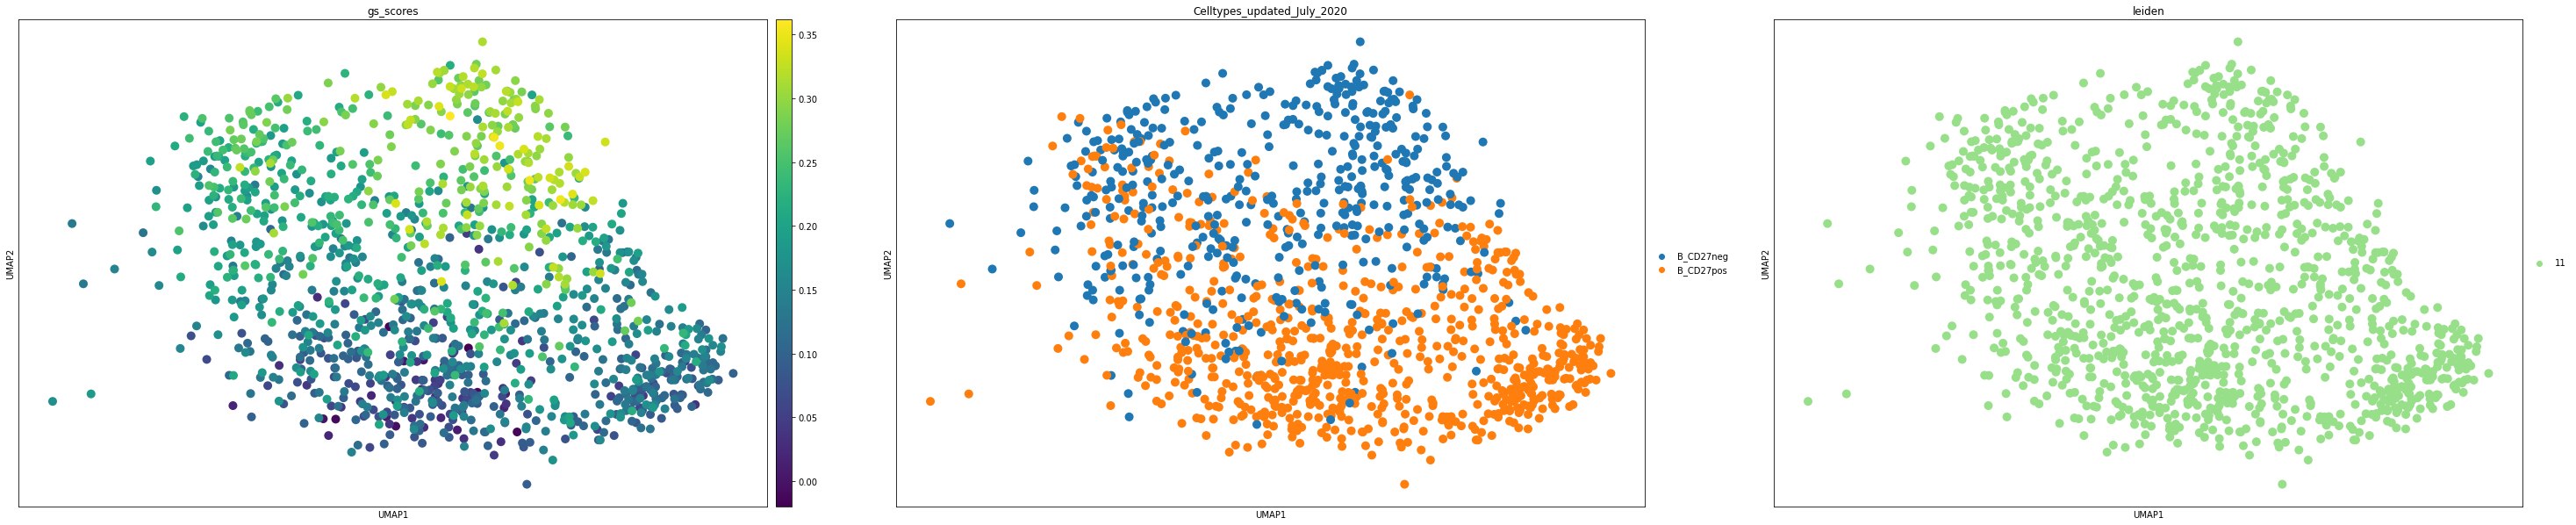

In [265]:
sc.pl.umap(adata=subq2, color=['gs_scores', 'Celltypes_updated_July_2020', 'leiden'], size=400)

In [ ]:
subq.obs[subq.obs.gs_scores > 0.15]

In [200]:
np.where(subq.obs.index == "GTCTTCGAGGGCACTA-1-HCATisStab7413620")

(array([3]),)

In [201]:

subq.obs.iloc[3]

Donor                                       328C
Time                                         12h
donor_time                              328C_12h
organ                                 Oesophagus
patient                                     328C
sample                         HCATisStab7413620
n_genes                                      585
percent_mito                           0.0494636
n_counts                                    1678
leiden                                        11
Celltypes_GenomeBiol_2019              B_CD27pos
Celltypes_updated_July_2020            B_CD27pos
Bcells                                    Bcells
gs_scores                               0.245626
Name: GTCTTCGAGGGCACTA-1-HCATisStab7413620, dtype: object

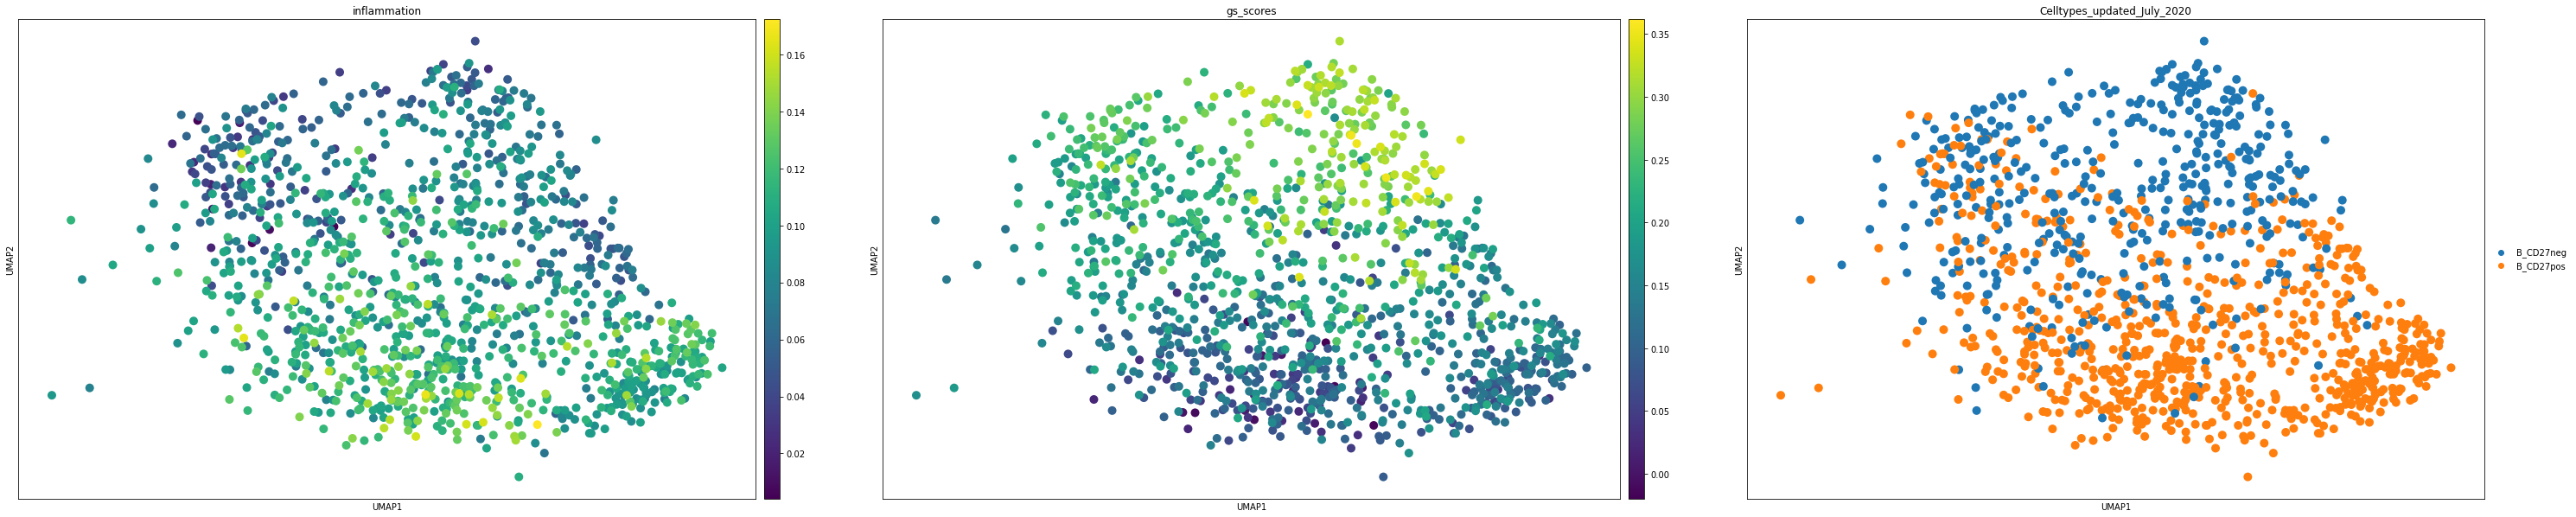

In [272]:
gene_set2 = gd['HALLMARK_INFLAMMATORY_RESPONSE']

noise_trials = 0
num_neighbors = 100
samp_neighbors = 81
res0 = neighborhood_scores(subq2, noise_trials, num_neighbors, samp_neighbors, gene_set2, 'average')
subq2.obs['inflammation'] = res0

sc.pl.umap(adata=subq2, color=['inflammation', 'gs_scores', 'Celltypes_updated_July_2020'], size=700)

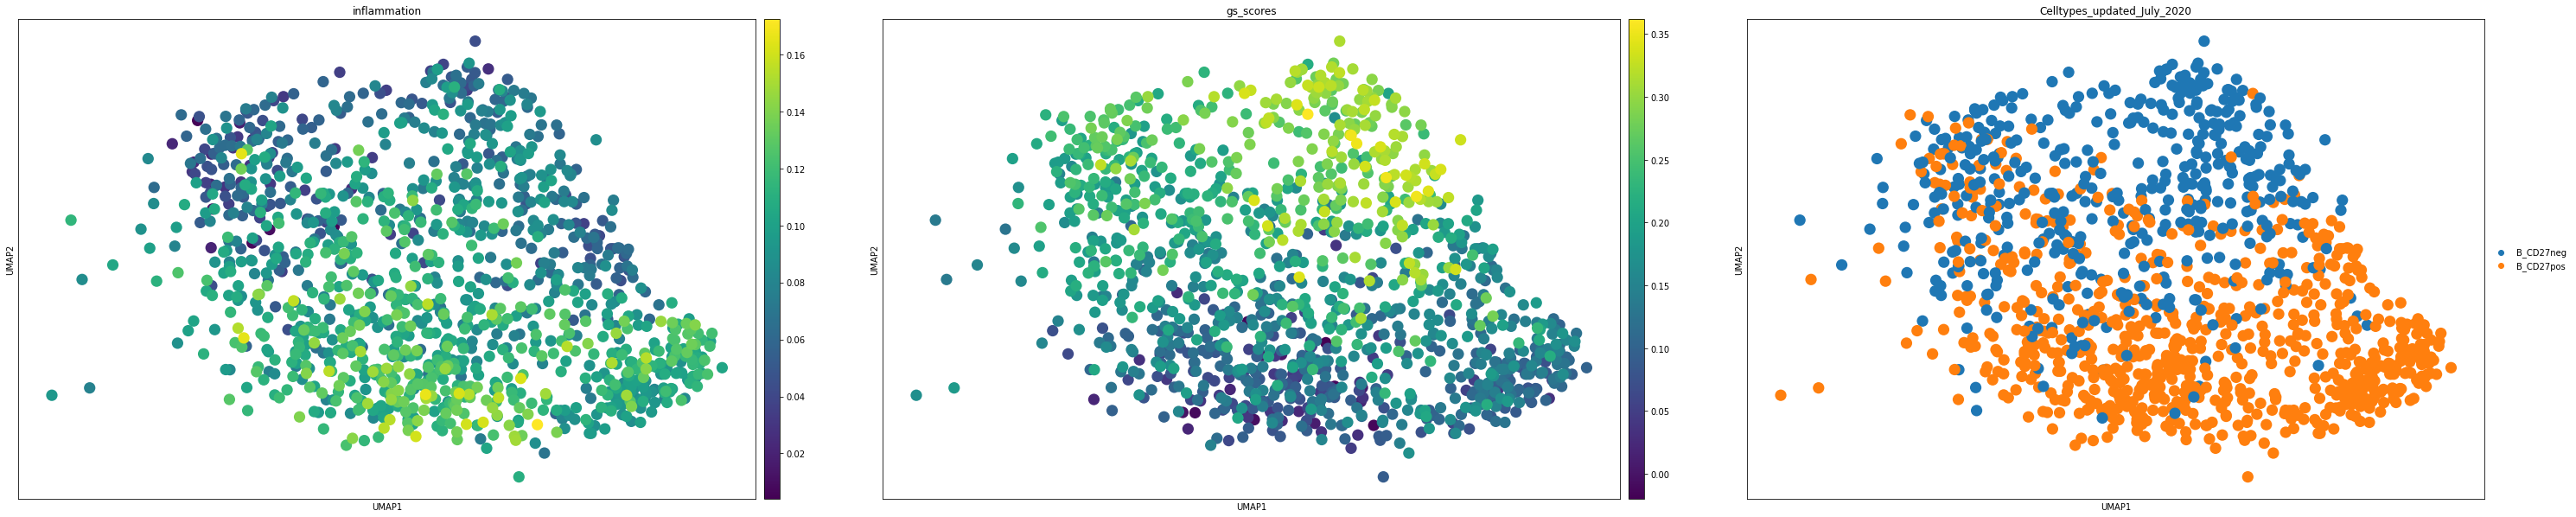

In [273]:
sc.pl.umap(adata=subq2, color=['inflammation', 'gs_scores', 'Celltypes_updated_July_2020'], size=700)